# Surface Cracking Detection : ResNet50 (Pretrained)

227 X 227 X RGB

20,000 images for Pos/Neg each
 -> 5,000 images  (데이터셋 축소)

Base Model: ResNet50 (pretrained weights by ImageNet)

# 제약 사항

- random seed 821
- train / val / test = 6: 2: 2  (6,000 : 2,000 : 2,000)
- loss function : binary crossentropy
- epoch = Early Stopping (Val_recall max, 10 patience) 

- dropout:  0.1 

- optimizer = MiniBatch SDG, MOMENTUM(모멘텀 계수 0.9), ADAM
- batch_size = 64, 128 / mini batch SGD의 batch_size = 32 
- lr = decaying (지나치게 빠른 학습 속도 조절)

- model.fit_generator 시 ModelCheckpoint 추가
- metric: confusion matrix (실제 균열을 모델이 균열로 인식한 확률)

라이브러리 임포트

In [1]:
import sklearn
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model,layers
from keras.metrics import Recall

import numpy as np
import os
from shutil import copyfile

random.seed(821)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

데이터셋 로드

In [2]:
os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

!kaggle datasets download -d arunrk7/surface-crack-detection
!unzip -q surface-crack-detection.zip

 93% 217M/233M [00:04<00:00, 89.1MB/s]
100% 233M/233M [00:04<00:00, 54.7MB/s]


In [3]:
print(len(os.listdir("Positive")))
print(len(os.listdir("Positive")))

20000
20000


In [4]:
os.mkdir('/tmp/concrete')
os.mkdir('/tmp/concrete/training')
os.mkdir('/tmp/concrete/testing')
os.mkdir('/tmp/concrete/valid')
os.mkdir('/tmp/concrete/training/positive')
os.mkdir('/tmp/concrete/training/negative')
os.mkdir('/tmp/concrete/testing/positive')
os.mkdir('/tmp/concrete/testing/negative')
os.mkdir('/tmp/concrete/valid/positive')
os.mkdir('/tmp/concrete/valid/negative')
os.mkdir('/tmp/checkpoint')

In [5]:
def split_data(SOURCE,TRAINING,VALID,TESTING,TRAINING_SIZE,VALID_SIZE,DATA_RATIO):
    files=[]
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + "is zero length, so ignoring.")
    training_length = int(len(files)*TRAINING_SIZE*DATA_RATIO) # Modified: We are trying to downsize the samples by using "DATA_RATIO" instead of using the whole image sets.
    valid_length = int(len(files)*VALID_SIZE*DATA_RATIO)
    testing_length = int(len(files)*(1-TRAINING_SIZE-VALID_SIZE)*DATA_RATIO)
    shuffled_set = random.sample(files,int(DATA_RATIO*(len(files))))
    valid_set = shuffled_set[0:valid_length]
    training_set = shuffled_set[valid_length:-testing_length]
    testing_set = shuffled_set[-testing_length:]
    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file,destination)
    for filename in valid_set:
        this_file = SOURCE + filename
        destination = VALID + filename
        copyfile(this_file,destination)
    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file,destination)
        
POSITIVE_SOURCE_DIR = "/content/Positive/"
NEGATIVE_SOURCE_DIR = "/content/Negative/"
TRAINING_POSITIVE_DIR = '/tmp/concrete/training/positive/'  
TRAINING_NEGATIVE_DIR = '/tmp/concrete/training/negative/'   
VALID_POSITIVE_DIR = '/tmp/concrete/valid/positive/'  
VALID_NEGATIVE_DIR = '/tmp/concrete/valid/negative/'   
TESTING_POSITIVE_DIR = '/tmp/concrete/testing/positive/'
TESTING_NEGATIVE_DIR = '/tmp/concrete/testing/negative/'

# Since we have set the train/val/test ratio as 6:2:2,
training_size = 0.6
valid_size = 0.2
data_ratio = 0.25
split_data(POSITIVE_SOURCE_DIR, TRAINING_POSITIVE_DIR, VALID_POSITIVE_DIR,TESTING_POSITIVE_DIR, training_size, valid_size, data_ratio)
split_data(NEGATIVE_SOURCE_DIR, TRAINING_NEGATIVE_DIR, VALID_NEGATIVE_DIR,TESTING_NEGATIVE_DIR, training_size, valid_size, data_ratio)

In [6]:
print(len(os.listdir('/tmp/concrete/training/positive/')))
print(len(os.listdir('/tmp/concrete/training/negative/')))
print(len(os.listdir('/tmp/concrete/testing/positive/')))
print(len(os.listdir('/tmp/concrete/testing/negative/')))
print(len(os.listdir('/tmp/concrete/valid/positive/')))
print(len(os.listdir('/tmp/concrete/valid/negative/')))

3000
3000
1000
1000
1000
1000


In [7]:
from keras import backend as K # Modified: Contents in confusion matrix are now included to show the exact performance of our models.

def recall_m(y_true, y_pred): # TPR
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # P
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # TP + FP
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def TP(y_true, y_pred):
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # TP
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    return tp/n

def TN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_neg * y_pred_neg, 0, 1))) # TN
    return tn/n

def FP(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    tn = K.sum(K.round(K.clip(y_neg * y_pred, 0, 1))) # FP
    return tn/n

def FN(y_true, y_pred):
    y_pos = K.round(K.clip(y_true, 0, 1))
    n_pos = K.sum(y_pos)
    y_neg = 1 - y_pos
    n_neg = K.sum(y_neg)
    n = n_pos + n_neg
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    tn = K.sum(K.round(K.clip(y_true * y_pred_neg, 0, 1))) # FN
    return tn/n


# ResNet50 적용

In [8]:
from tensorflow.keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# 1. Optimizer = Adam
- dropout = 0.1
- batch size = 64 / 128
- loss = binary_crossentropy
- epoch = Earlystopping(maximize val_recall / patience=10)
- optimizer = Adam(learning_rate = 0.1 / 0.01 with time-based decaying process)

In [9]:
# Creating ResNet50 (pre-trained weights by imagenet) optimized by Adam

def ResNet_Adam(batchsize, dropout, learning_rate, epochs):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate),loss='binary_crossentropy', metrics=['Recall','Precision',TP,TN,FP,FN]) # learning rate (decaying itself in Adam)
  
  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary') # batch size
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = batchsize, class_mode = 'binary', target_size = (227,227))
  TESTING_DIR = '/tmp/concrete/testing/'
  test_datagen = ImageDataGenerator(rescale = 1/255)
  test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary')

  checkpoint_path = 'tmp/'+'Adam'+str(batchsize)+str(learning_rate)+'/'+'checkpoint-{epoch:04d}.ckpt'

 # Early stopping with patience=10
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc= ModelCheckpoint(checkpoint_path, monitor='val_recall', mode='max',save_best_only= True, save_weights_only = True)
  history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch = 10, validation_data=valid_generator, verbose = 1, callbacks = [early_stopping,mc])

  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("\nEpochs here are :", len(rec))
  fig, ax = plt.subplots(3, 1,figsize=(5,10))
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)
  ax[2].plot(history.history['precision'], color = 'b', label = "Training precision")
  ax[2].plot(history.history['val_precision'], color='r', label = "Validation precision", axes = ax[2])
  legend = ax[2].legend(loc = (1.05,0), shadow = True)

  return model, test_generator


In [10]:
def eval_test(model, test_generator, optimizer, batch_size, learning_rate):
  latest = tf.train.latest_checkpoint('tmp/'+optimizer+str(batch_size)+str(learning_rate))
  check = str(latest)
  model.load_weights(check)
  print("\nThe best weights for the model is saved in ", check)
  print("\nTest result here is")
  result = model.evaluate(test_generator)


## 1.1. Batch Size = 64 & Learning Rate = 0.1 (decaying)

94773248/94765736 [==============================] - 1s 0us/step
Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 48s 1s/step - loss: 9.6274 - recall: 0.4371 - precision: 0.5305 - TP: 0.2191 - TN: 0.2984 - FP: 0.2034 - FN: 0.2792 - val_loss: 5.2015 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4985 - val_TN: 0.0000e+00 - val_FP: 0.5015 - val_FN: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 9s 985ms/step - loss: 3.2146 - recall: 0.4980 - precision: 0.5399 - TP: 0.2566 - TN: 0.2628 - FP: 0.2226 - FN: 0.2580 - val_loss: 5.9493 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4971 - val_FP: 0.0000e+00 - val_FN: 0.5029
Epoch 3/100
10/10 [==============================] - 9s 989ms/step - loss: 3.7787 - recall: 0.4288 - precision: 0.4252 - TP: 0.2117 - TN: 0.3113 - FP: 0.1953 - FN: 0.2817 - val_loss: 3.3322 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4956 - val_TN: 0.0000e+00 - val_FP: 0.5044 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 9s 998ms

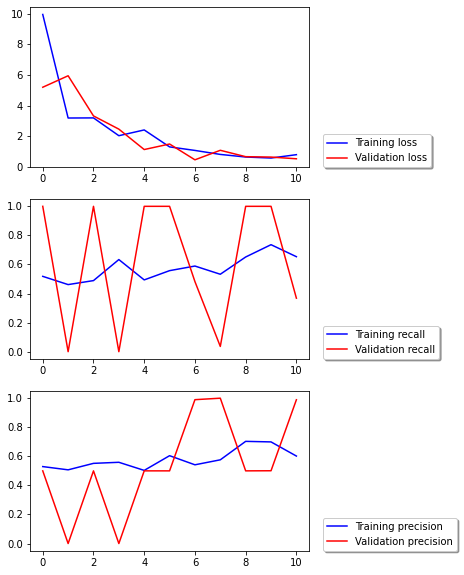

In [11]:
model, test_generator = ResNet_Adam(batchsize = 64, dropout = 0.1, learning_rate = 0.1, epochs = 100)

In [12]:
eval_test(model = model, test_generator = test_generator, optimizer = 'Adam', batch_size = 64, learning_rate = 0.1)


The best weights for the model is saved in  tmp/Adam640.1/checkpoint-0001.ckpt

Test result here is
32/32 [==============================] - 7s 218ms/step - loss: 5.1967 - recall: 1.0000 - precision: 0.5000 - TP: 0.5015 - TN: 0.0000e+00 - FP: 0.4985 - FN: 0.0000e+00


## 1.2. Batch Size = 64 & Learning Rate = 0.01 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 0.8469 - recall: 0.4055 - precision: 0.4815 - TP: 0.2052 - TN: 0.3270 - FP: 0.1808 - FN: 0.2871 - val_loss: 0.6993 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4985 - val_FP: 0.0000e+00 - val_FN: 0.5015
Epoch 2/100
10/10 [==============================] - 10s 1s/step - loss: 0.6980 - recall: 0.3591 - precision: 0.4752 - TP: 0.1745 - TN: 0.3560 - FP: 0.1655 - FN: 0.3040 - val_loss: 0.6971 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5000 - val_FP: 0.0000e+00 - val_FN: 0.5000
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 0.7029 - recall: 0.3431 - precision: 0.5675 - TP: 0.1701 - TN: 0.3538 - FP: 0.1528 - FN: 0.3233 - val_loss: 0.7326 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4985 - val_TN: 0.0000e+00 - val_FP: 0.5015 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 10s 

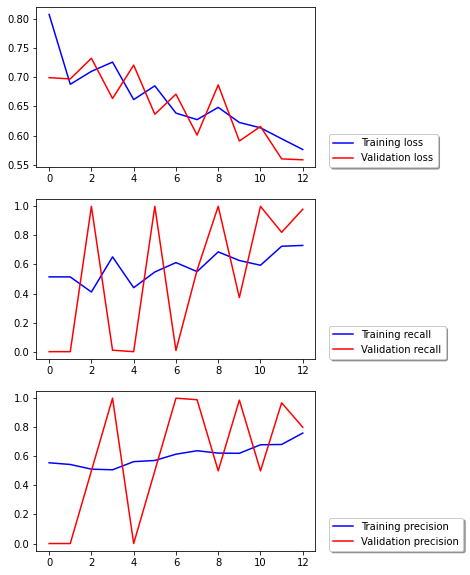

In [13]:
model, test_generator = ResNet_Adam(batchsize = 64, dropout = 0.1, learning_rate = 0.01, epochs = 100)

In [14]:
eval_test(model = model, test_generator = test_generator, optimizer = 'Adam', batch_size = 64, learning_rate = 0.01)


The best weights for the model is saved in  tmp/Adam640.01/checkpoint-0003.ckpt

Test result here is
32/32 [==============================] - 7s 221ms/step - loss: 0.7308 - recall: 1.0000 - precision: 0.5000 - TP: 0.5015 - TN: 0.0000e+00 - FP: 0.4985 - FN: 0.0000e+00


## 1.3. Batch Size = 128 & Learning Rate = 0.1 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 20s 2s/step - loss: 8.6913 - recall: 0.4483 - precision: 0.5092 - TP: 0.2234 - TN: 0.2952 - FP: 0.2077 - FN: 0.2737 - val_loss: 5.7982 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4991 - val_TN: 0.0000e+00 - val_FP: 0.5009 - val_FN: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 4.4687 - recall: 0.4537 - precision: 0.4664 - TP: 0.2166 - TN: 0.2723 - FP: 0.2471 - FN: 0.2640 - val_loss: 5.4373 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4991 - val_FP: 0.0000e+00 - val_FN: 0.5009
Epoch 3/100
10/10 [==============================] - 14s 1s/step - loss: 3.4163 - recall: 0.4106 - precision: 0.4879 - TP: 0.2097 - TN: 0.3371 - FP: 0.1502 - FN: 0.3030 - val_loss: 1.9276 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5009 - val_TN: 0.0000e+00 - val_FP: 0.4991 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 12s 1s/step 

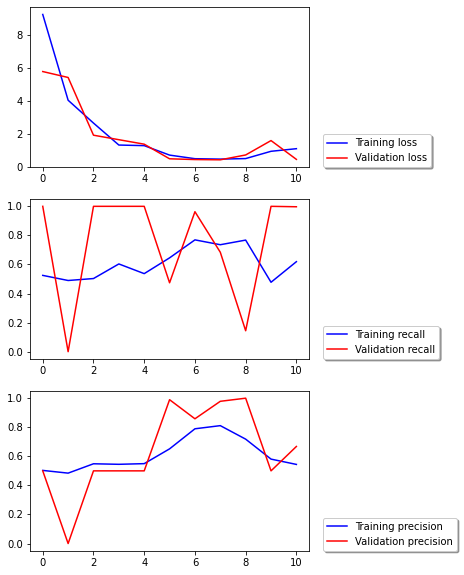

In [15]:
model, test_generator = ResNet_Adam(batchsize = 128, dropout = 0.1, learning_rate = 0.1, epochs = 100)

In [16]:
eval_test(model = model, test_generator = test_generator, optimizer = 'Adam', batch_size = 128, learning_rate = 0.1)


The best weights for the model is saved in  tmp/Adam1280.1/checkpoint-0001.ckpt

Test result here is
16/16 [==============================] - 7s 436ms/step - loss: 5.7952 - recall: 1.0000 - precision: 0.5000 - TP: 0.4985 - TN: 0.0000e+00 - FP: 0.5015 - FN: 0.0000e+00


## 1.4. Batch Size = 128 & Learning Rate = 0.01 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 17s 1s/step - loss: 1.0586 - recall: 0.4390 - precision: 0.4683 - TP: 0.2275 - TN: 0.2706 - FP: 0.2145 - FN: 0.2874 - val_loss: 0.6858 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5000 - val_TN: 0.0000e+00 - val_FP: 0.5000 - val_FN: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.7705 - recall: 0.4393 - precision: 0.5210 - TP: 0.2263 - TN: 0.2755 - FP: 0.2068 - FN: 0.2913 - val_loss: 0.7520 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4988 - val_FP: 0.0000e+00 - val_FN: 0.5012
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.7353 - recall: 0.2662 - precision: 0.4743 - TP: 0.1330 - TN: 0.3770 - FP: 0.1286 - FN: 0.3614 - val_loss: 0.7430 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5018 - val_FP: 0.0000e+00 - val_FN: 0.4982
Epoch 4/100
10/10 [==============================] - 12s 

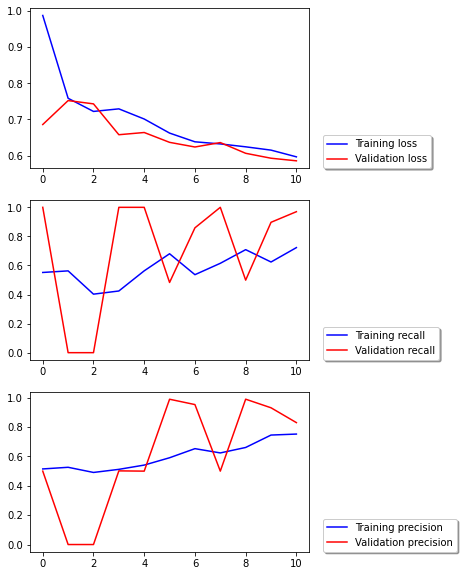

In [17]:
model, test_generator = ResNet_Adam(batchsize = 128, dropout = 0.1, learning_rate = 0.01, epochs = 100)

In [18]:
eval_test(model = model, test_generator = test_generator, optimizer = 'Adam', batch_size = 128, learning_rate = 0.01)


The best weights for the model is saved in  tmp/Adam1280.01/checkpoint-0001.ckpt

Test result here is
16/16 [==============================] - 7s 434ms/step - loss: 0.6855 - recall: 1.0000 - precision: 0.5000 - TP: 0.5018 - TN: 0.0000e+00 - FP: 0.4982 - FN: 0.0000e+00


# 2. Optimizer = Momentum SGD (0.9)

- dropout = 0.1
- batch size = 64 / 128
- loss = binary_crossentropy
- epoch = Earlystopping(maximize val_recall / patience=10)
- optimizer = Adam(learning_rate = 0.1 / 0.01 with time-based decaying process)

In [19]:
# Creating ResNet50 (pre-trained weights by imagenet) optimized by SGD Momentum 0.9

def ResNet_MomentumSGD(batchsize, dropout, learning_rate, epochs):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, momentum=0.9, decay = learning_rate/epochs),loss='binary_crossentropy', metrics=['Recall','Precision',TP,TN,FP,FN]) # learning rate (decaying by every epoch)
  
  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary') # batch size
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = batchsize, class_mode = 'binary', target_size = (227,227))
  TESTING_DIR = '/tmp/concrete/testing/'
  test_datagen = ImageDataGenerator(rescale = 1/255)
  test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary')

  checkpoint_path = 'tmp/'+'MomentumSGD'+str(batchsize)+str(learning_rate)+'/'+'checkpoint-{epoch:04d}.ckpt'

 # Early stopping with patience=10
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc= ModelCheckpoint(checkpoint_path, monitor='val_recall', mode='max',save_best_only= True, save_weights_only = True)
  history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch = 10, validation_data=valid_generator, verbose = 1, callbacks = [early_stopping,mc])

  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("\nEpochs here are :", len(rec))
  fig, ax = plt.subplots(3, 1,figsize=(5,10))
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)
  ax[2].plot(history.history['precision'], color = 'b', label = "Training precision")
  ax[2].plot(history.history['val_precision'], color='r', label = "Validation precision", axes = ax[2])
  legend = ax[2].legend(loc = (1.05,0), shadow = True)

  return model, test_generator


## 2.1. Batch Size = 64 & Learning Rate = 0.1 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 8.2502 - recall: 0.4495 - precision: 0.5417 - TP: 0.2346 - TN: 0.2665 - FP: 0.2079 - FN: 0.2911 - val_loss: 1.0660 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5015 - val_FP: 0.0000e+00 - val_FN: 0.4985
Epoch 2/100
10/10 [==============================] - 9s 1s/step - loss: 28.5985 - recall: 0.5426 - precision: 0.4846 - TP: 0.2697 - TN: 0.1951 - FP: 0.3010 - FN: 0.2342 - val_loss: 36.1235 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5000 - val_TN: 0.0000e+00 - val_FP: 0.5000 - val_FN: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 33.8218 - recall: 0.6612 - precision: 0.4620 - TP: 0.3143 - TN: 0.1458 - FP: 0.3706 - FN: 0.1693 - val_loss: 21.9939 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5073 - val_TN: 0.0000e+00 - val_FP: 0.4927 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 10s 1s/st

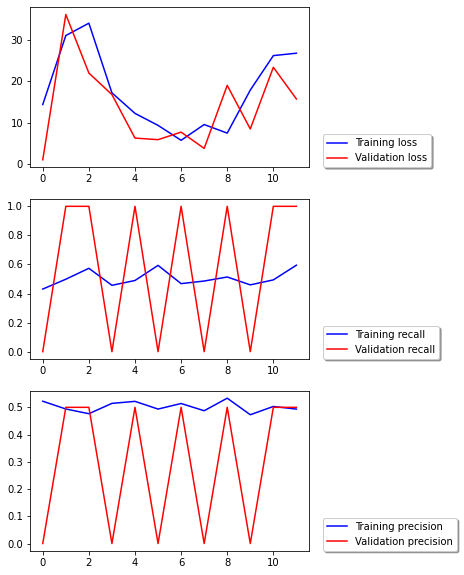

In [20]:
model, test_generator = ResNet_MomentumSGD(batchsize = 64, dropout = 0.1, learning_rate = 0.1, epochs = 100)

In [21]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MomentumSGD', batch_size = 64, learning_rate = 0.1)


The best weights for the model is saved in  tmp/MomentumSGD640.1/checkpoint-0002.ckpt

Test result here is
32/32 [==============================] - 7s 222ms/step - loss: 36.1080 - recall: 1.0000 - precision: 0.5000 - TP: 0.4971 - TN: 0.0000e+00 - FP: 0.5029 - FN: 0.0000e+00


## 2.2. Batch Size = 64 & Learning Rate = 0.01 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 0.7222 - recall: 0.4986 - precision: 0.4825 - TP: 0.2526 - TN: 0.2235 - FP: 0.2705 - FN: 0.2534 - val_loss: 0.7361 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4985 - val_TN: 0.0000e+00 - val_FP: 0.5015 - val_FN: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 9s 1s/step - loss: 0.7716 - recall: 0.6281 - precision: 0.4863 - TP: 0.3160 - TN: 0.1636 - FP: 0.3325 - FN: 0.1880 - val_loss: 0.6882 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5000 - val_FP: 0.0000e+00 - val_FN: 0.5000
Epoch 3/100
10/10 [==============================] - 10s 1s/step - loss: 0.7131 - recall: 0.3834 - precision: 0.5606 - TP: 0.1813 - TN: 0.3605 - FP: 0.1682 - FN: 0.2900 - val_loss: 0.6762 - val_recall: 0.0010 - val_precision: 1.0000 - val_TP: 4.8828e-04 - val_TN: 0.5015 - val_FP: 0.0000e+00 - val_FN: 0.4980
Epoch 4/100
10/10 [==============================] - 10s 1s/step -

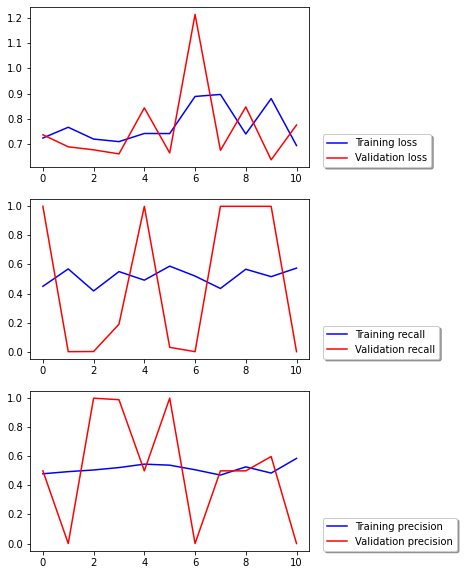

In [22]:
model, test_generator = ResNet_MomentumSGD(batchsize = 64, dropout = 0.1, learning_rate = 0.01, epochs = 100)

In [23]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MomentumSGD', batch_size = 64, learning_rate = 0.01)


The best weights for the model is saved in  tmp/MomentumSGD640.01/checkpoint-0001.ckpt

Test result here is
32/32 [==============================] - 7s 220ms/step - loss: 0.7364 - recall: 1.0000 - precision: 0.5000 - TP: 0.5044 - TN: 0.0000e+00 - FP: 0.4956 - FN: 0.0000e+00


## 2.3. Batch Size = 128 & Learning Rate = 0.1 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 17s 1s/step - loss: 8.8524 - recall: 0.6058 - precision: 0.4972 - TP: 0.3031 - TN: 0.1939 - FP: 0.3061 - FN: 0.1970 - val_loss: 5.1433 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4991 - val_FP: 0.0000e+00 - val_FN: 0.5009
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 8.7439 - recall: 0.3161 - precision: 0.4504 - TP: 0.1563 - TN: 0.3694 - FP: 0.1326 - FN: 0.3417 - val_loss: 19.8951 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4982 - val_TN: 0.0000e+00 - val_FP: 0.5018 - val_FN: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 17.7042 - recall: 0.4672 - precision: 0.4649 - TP: 0.2264 - TN: 0.2473 - FP: 0.2615 - FN: 0.2648 - val_loss: 14.9261 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.4985 - val_TN: 0.0000e+00 - val_FP: 0.5015 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 12s 1s/st

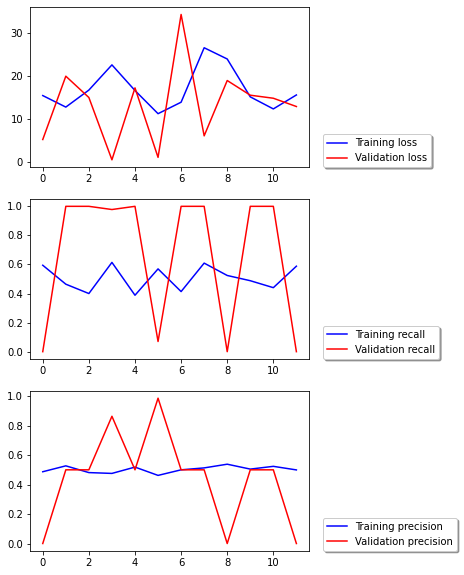

In [24]:
model, test_generator = ResNet_MomentumSGD(batchsize = 128, dropout = 0.1, learning_rate = 0.1, epochs = 100)

In [25]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MomentumSGD', batch_size = 128, learning_rate = 0.1)


The best weights for the model is saved in  tmp/MomentumSGD1280.1/checkpoint-0002.ckpt

Test result here is
16/16 [==============================] - 7s 436ms/step - loss: 19.8849 - recall: 1.0000 - precision: 0.5000 - TP: 0.4997 - TN: 0.0000e+00 - FP: 0.5003 - FN: 0.0000e+00


## 2.4. Batch Size = 128 & Learning Rate = 0.01 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 17s 1s/step - loss: 0.7194 - recall: 0.4786 - precision: 0.4809 - TP: 0.2288 - TN: 0.2782 - FP: 0.2454 - FN: 0.2477 - val_loss: 0.7849 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5018 - val_TN: 0.0000e+00 - val_FP: 0.4982 - val_FN: 0.0000e+00
Epoch 2/100
10/10 [==============================] - 12s 1s/step - loss: 0.8124 - recall: 0.6204 - precision: 0.5056 - TP: 0.3138 - TN: 0.1824 - FP: 0.3098 - FN: 0.1940 - val_loss: 0.8727 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5000 - val_TN: 0.0000e+00 - val_FP: 0.5000 - val_FN: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 12s 1s/step - loss: 0.9354 - recall: 0.5562 - precision: 0.4918 - TP: 0.2757 - TN: 0.2157 - FP: 0.2859 - FN: 0.2226 - val_loss: 0.7262 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5009 - val_FP: 0.0000e+00 - val_FN: 0.4991
Epoch 4/100
10/10 [==============================] - 12s 1s/step 

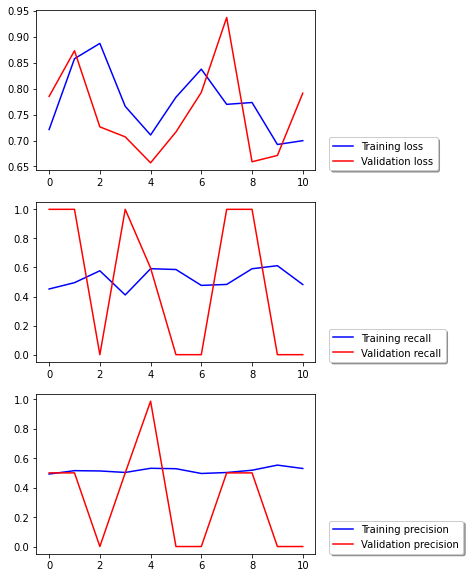

In [26]:
model, test_generator = ResNet_MomentumSGD(batchsize = 128, dropout = 0.1, learning_rate = 0.01, epochs = 100)

In [27]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MomentumSGD', batch_size = 128, learning_rate = 0.01)


The best weights for the model is saved in  tmp/MomentumSGD1280.01/checkpoint-0001.ckpt

Test result here is
16/16 [==============================] - 7s 434ms/step - loss: 0.7852 - recall: 1.0000 - precision: 0.5000 - TP: 0.4979 - TN: 0.0000e+00 - FP: 0.5021 - FN: 0.0000e+00


# 3. Optimizer = MiniBatch SGD (32)

- dropout = 0.1
- batch size = 32
- loss = binary_crossentropy
- epoch = Earlystopping(maximize val_recall / patience=10)
- optimizer = MomentumSGD(learning_rate = 0.1 / 0.01 with time-based decaying process)

In [28]:
# Creating ResNet50 (pre-trained weights by imagenet) optimized by SGD MiniBatch 32

def ResNet_MinibatchSGD(batchsize, dropout, learning_rate, epochs):
  pre_trained_model_ResNet = keras.applications.resnet50.ResNet50(weights="imagenet",  # ResNet50 모델 사용. imagenet에서 학습된 weight
                                                  input_shape = (227, 227, 3),  # input shape = (227, 227, 3)
                                                  include_top=False)  # convolution layer만 가져오겠다는 뜻. fully connected layer는 off
  for layer in pre_trained_model_ResNet.layers:
    layer.trainable = False

  model = Sequential()
  model.add(pre_trained_model_ResNet)
  model.add(layers.GlobalAveragePooling2D()) # 2D로 만들기 
  model.add(layers.Dropout(dropout)) # Dropout
  model.add(layers.Dense(1, activation='sigmoid')) # binary classification이므로 타겟 클래스에 대한 확률 인코딩

  model.compile(optimizer=keras.optimizers.SGD(lr=learning_rate, decay = learning_rate/epochs),loss='binary_crossentropy', metrics=['Recall','Precision',TP,TN,FP,FN]) # learning rate (decaying by every epoch)
  
  TRAINING_DIR = '/tmp/concrete/training/'
  train_datagen = ImageDataGenerator(rescale = 1/255)
  train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary') # batch size
  VALIDATION_DIR = '/tmp/concrete/valid/'
  valid_datagen = ImageDataGenerator(rescale = 1/255)
  valid_generator = valid_datagen.flow_from_directory(VALIDATION_DIR, batch_size = batchsize, class_mode = 'binary', target_size = (227,227))
  TESTING_DIR = '/tmp/concrete/testing/'
  test_datagen = ImageDataGenerator(rescale = 1/255)
  test_generator = test_datagen.flow_from_directory(TESTING_DIR, batch_size = batchsize, target_size = (227,227), class_mode = 'binary')

  checkpoint_path = 'tmp/'+'MinibatchSGD'+str(batchsize)+str(learning_rate)+'/'+'checkpoint-{epoch:04d}.ckpt'

 # Early stopping with patience=10
  early_stopping=EarlyStopping(monitor='val_recall',mode='max',verbose=1,patience = 10)
  mc= ModelCheckpoint(checkpoint_path, monitor='val_recall', mode='max', save_best_only=True,save_weights_only=True)
  history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch = 10, validation_data=valid_generator, verbose = 1, callbacks = [early_stopping,mc])

  # Plotting Graphs
  rec = history.history['recall']
  val_rec = history.history['val_recall']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  print("\nEpochs here are :", len(rec))
  fig, ax = plt.subplots(3, 1,figsize=(5,10))
  ax[0].plot(history.history['loss'], color = 'b', label = "Training loss")
  ax[0].plot(history.history['val_loss'], color='r', label = "Validation loss", axes = ax[0])
  legend = ax[0].legend(loc=(1.05,0), shadow = True)
  ax[1].plot(history.history['recall'], color = 'b', label = "Training recall")
  ax[1].plot(history.history['val_recall'], color = 'r', label = "Validation recall")
  legend = ax[1].legend(loc = (1.05,0), shadow = True)
  ax[2].plot(history.history['precision'], color = 'b', label = "Training precision")
  ax[2].plot(history.history['val_precision'], color='r', label = "Validation precision", axes = ax[2])
  legend = ax[2].legend(loc = (1.05,0), shadow = True)

  return model, test_generator


## 3.1. Batch Size = 32 & Learning Rate = 0.1 (decaying)

Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 14s 1s/step - loss: 7.2006 - recall: 0.5762 - precision: 0.5285 - TP: 0.3145 - TN: 0.1819 - FP: 0.2763 - FN: 0.2272 - val_loss: 13.4558 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.4985 - val_FP: 0.0000e+00 - val_FN: 0.5015
Epoch 2/100
10/10 [==============================] - 9s 932ms/step - loss: 9.4324 - recall: 0.4421 - precision: 0.4904 - TP: 0.2295 - TN: 0.2862 - FP: 0.1967 - FN: 0.2876 - val_loss: 2.7956 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5005 - val_TN: 0.0000e+00 - val_FP: 0.4995 - val_FN: 0.0000e+00
Epoch 3/100
10/10 [==============================] - 9s 942ms/step - loss: 9.7231 - recall: 0.4007 - precision: 0.3563 - TP: 0.1686 - TN: 0.2487 - FP: 0.3116 - FN: 0.2712 - val_loss: 12.7593 - val_recall: 1.0000 - val_precision: 0.5000 - val_TP: 0.5000 - val_TN: 0.0000e+00 - val_FP: 0.5000 - val_FN: 0.0000e+00
Epoch 4/100
10/10 [==============================] - 9s 948

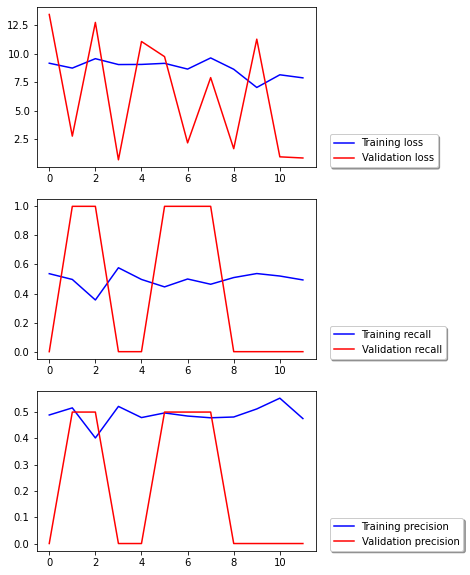

In [29]:
model, test_generator = ResNet_MinibatchSGD(batchsize = 32, dropout =0.1, learning_rate = 0.1, epochs = 100)

In [30]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MinibatchSGD', batch_size = 32, learning_rate = 0.1)


The best weights for the model is saved in  tmp/MinibatchSGD320.1/checkpoint-0002.ckpt

Test result here is
63/63 [==============================] - 7s 118ms/step - loss: 2.7946 - recall: 1.0000 - precision: 0.5000 - TP: 0.5010 - TN: 0.0000e+00 - FP: 0.4990 - FN: 0.0000e+00


## 3.2. Batch Size = 32 & Learning Rate = 0.01 (decaying)



Found 6000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 13s 1s/step - loss: 0.7990 - recall: 0.3958 - precision: 0.4233 - TP: 0.1948 - TN: 0.2823 - FP: 0.2228 - FN: 0.3002 - val_loss: 0.6894 - val_recall: 0.5990 - val_precision: 0.8644 - val_TP: 0.2971 - val_TN: 0.4549 - val_FP: 0.0466 - val_FN: 0.2014
Epoch 2/100
10/10 [==============================] - 9s 933ms/step - loss: 0.7533 - recall: 0.4812 - precision: 0.4379 - TP: 0.2211 - TN: 0.2556 - FP: 0.2831 - FN: 0.2402 - val_loss: 0.6921 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_TP: 0.0000e+00 - val_TN: 0.5010 - val_FP: 0.0000e+00 - val_FN: 0.4990
Epoch 3/100
10/10 [==============================] - 9s 940ms/step - loss: 0.7668 - recall: 0.4118 - precision: 0.5605 - TP: 0.2129 - TN: 0.2868 - FP: 0.1918 - FN: 0.3086 - val_loss: 0.6866 - val_recall: 0.5160 - val_precision: 0.9773 - val_TP: 0.2594 - val_TN: 0.4926 - val_FP: 0.0060 - val_FN: 0.2421
Epoch 4/100
10/10 [==============================] - 9s 938ms/step - loss: 0.

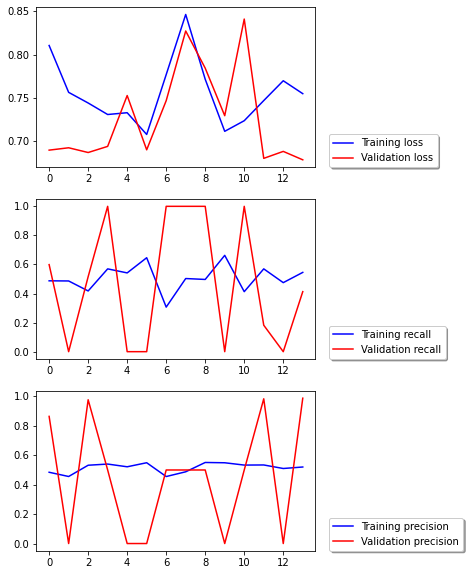

In [31]:
model, test_generator = ResNet_MinibatchSGD(batchsize = 32, dropout =0.1, learning_rate = 0.01, epochs = 100)

In [32]:
eval_test(model = model, test_generator = test_generator, optimizer = 'MinibatchSGD', batch_size = 32, learning_rate = 0.01)


The best weights for the model is saved in  tmp/MinibatchSGD320.01/checkpoint-0004.ckpt

Test result here is
63/63 [==============================] - 8s 118ms/step - loss: 0.6934 - recall: 1.0000 - precision: 0.5000 - TP: 0.4990 - TN: 0.0000e+00 - FP: 0.5010 - FN: 0.0000e+00
